In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


### Importing OSSL dataset

In [3]:
wet_chemistry_data = pd.read_csv('./dataset/ossl_soillab_L0_v1.2.csv')
spectral_data = pd.read_csv('./dataset/ossl_mir_L0_v1.2.csv')

soilsite_data = pd.read_csv('./dataset/ossl_soilsite_L0_v1.2.csv')

/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_87766/2492191570.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  wet_chemistry_data = pd.read_csv('./curr/ossl_soillab_L0_v1.2.csv')
/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_87766/2492191570.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  spectral_data = pd.read_csv('./curr/ossl_mir_L0_v1.2.csv')
/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_87766/2492191570.py:4: DtypeWarning: Columns (2,13,14,15,19,23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  soilsite_data = pd.read_csv('./curr/ossl_soilsite_L0_v1.2.csv')


### Merging dataset

In [61]:
merged_data = pd.merge( wet_chemistry_data, spectral_data, on='id.layer_uuid_txt')
merged_data = pd.merge( soilsite_data, merged_data, on='id.layer_uuid_txt')


In [60]:
#merged_data = merged_data[ merged_data["dataset.code_ascii_txt"]=="KSSL.SSL"]
merged_data.head()


,dataset.code_ascii_txt,id.layer_uuid_txt,id.layer_local_c,longitude.point_wgs84_dd,latitude.point_wgs84_dd,layer.sequence_usda_uint16,layer.upper.depth_usda_cm,layer.lower.depth_usda_cm,observation.date.begin_iso.8601_yyyy.mm.dd,observation.date.end_iso.8601_yyyy.mm.dd,...,scan_mir.3982_abs,scan_mir.3984_abs,scan_mir.3986_abs,scan_mir.3988_abs,scan_mir.3990_abs,scan_mir.3992_abs,scan_mir.3994_abs,scan_mir.3996_abs,scan_mir.3998_abs,scan_mir.4000_abs
0,AFSIS1.SSL,ded584d70bf0474202d30e575ae24784,icr072246,15.687492,-7.377750,1.0,0.0,20.0,2011-01-01,2013-12-31,...,0.35678,0.35664,0.35578,0.35474,0.35410,0.35366,0.35324,0.35292,0.35255,0.35205
1,AFSIS1.SSL,7c080e182bc23e19747629f46edbc6c4,icr072247,15.687492,-7.377750,2.0,20.0,50.0,2011-01-01,2013-12-31,...,0.35840,0.35814,0.35714,0.35598,0.35524,0.35472,0.35422,0.35382,0.35338,0.35280
2,AFSIS1.SSL,03bbd570dfd399bfd866ebcdf860de39,icr072266,15.687817,-7.351243,1.0,0.0,20.0,2011-01-01,2013-12-31,...,0.37252,0.37234,0.37142,0.37034,0.36968,0.36924,0.36881,0.36847,0.36808,0.36756
3,AFSIS1.SSL,887d316328ef950eeca33293bfe052bf,icr072267,15.687817,-7.351243,2.0,20.0,50.0,2011-01-01,2013-12-31,...,0.35799,0.35773,0.35671,0.35548,0.35468,0.35414,0.35362,0.35322,0.35276,0.35216
4,AFSIS1.SSL,ca03ce6e439b1909c5a4a771c0afa951,icr072286,15.687965,-7.331673,1.0,0.0,20.0,2011-01-01,2013-12-31,...,0.31625,0.31609,0.31510,0.31391,0.31321,0.31276,0.31231,0.31197,0.31157,0.31104


### Getting spectral and target colums name

In [62]:
spectral_columns = [col for col in merged_data.columns if 'scan_mir' in col]

target_column = 'c.tot_usda.a622_w.pct'  # Adjust to the actual column name

### Cleaning the Dataset and splitting features and target

In [63]:

## Removing null values
cleaned_data = merged_data.dropna(subset=spectral_columns + [target_column])



## Taking data from 10th Percentile to 90th percentile for removing outliers
q_low = cleaned_data[target_column].quantile(0.10)
q_hi  = cleaned_data[target_column].quantile(0.90)
cleaned_data_filtered = cleaned_data[(cleaned_data[target_column] < q_hi) & (cleaned_data[target_column] > q_low)]


## Taking sample data for feature and target split
#sampled_data = cleaned_data_filtered
sampled_data = cleaned_data_filtered.sample(n=10000, random_state=42)


X = sampled_data[spectral_columns]
y = sampled_data[target_column]




In [65]:
y.head()

49535     0.53352
84383     0.67791
82922    10.62177
52090     0.92547
53454     0.57429
Name: c.tot_usda.a622_w.pct, dtype: float64

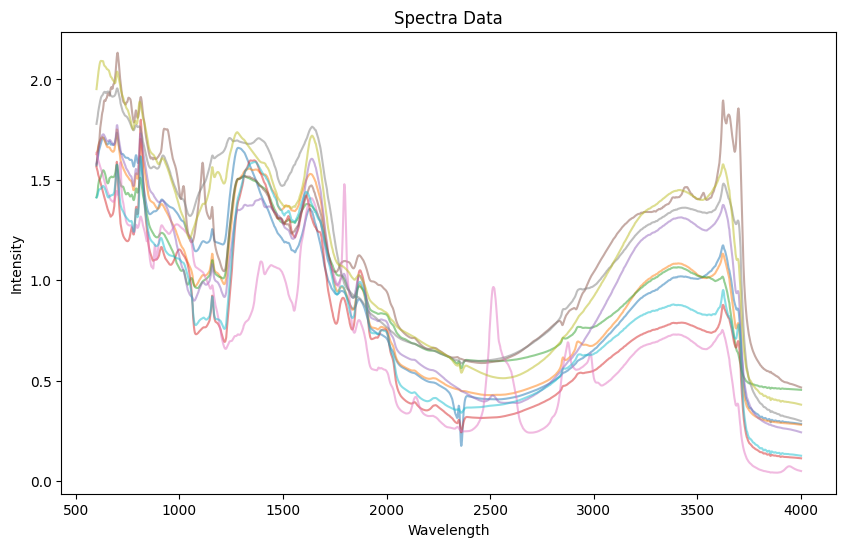

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Extract wavelength values from column names
wavelengths = np.array([int(col.split('.')[1].split('_')[0]) for col in X.columns])

# Plot the spectra data
plt.figure(figsize=(10, 6))
for i in range(0, len(X), 1000):  # Plot every 1000th sample to avoid clutter
    plt.plot(wavelengths, X.iloc[i, :], alpha=0.5)

plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Spectra Data')
plt.show()


### Splitting Training and Testing data

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Training the final model

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.utils import parallel_backend
import multiprocessing

# CPU cores
n_cores = multiprocessing.cpu_count()

# Hyperparameter space
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV with parallel computation using loky
with parallel_backend('loky', n_jobs=n_cores):
    random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42)

    # Perform the random search
    random_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)


best_rf_regressor = random_search.best_estimator_



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.1s


KeyboardInterrupt: 

#### Best Hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 790}


In [69]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(
    n_estimators=790,
    max_depth=15,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    bootstrap=False,
    random_state=42
)


rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_leaf=3, n_estimators=790, random_state=42)

In [70]:
import joblib

# Save the trained model to a file
joblib.dump(best_rf_regressor, 'random_forest_model_10k_mir.joblib')


['random_forest_model_10k_mir.joblib']

## Testing the Final Model and Evaluating

In [71]:
y_pred = best_rf_regressor.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

def lccc(y_true, y_pred):
    pearson_corr = np.corrcoef(y_true, y_pred)[0, 1]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)

    numerator = 2 * pearson_corr * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2

    return numerator / denominator

lccc_value = lccc(y_test, y_pred)

print(f'R^2: {r2}')
print                   (f'RMSE: {rmse}')
print(f'LCCC: {lccc_value}')

R^2: 0.9397260235879433
RMSE: 1.2606162419832965
LCCC: 0.971162217744775


In [72]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)


print(f'MAPE: {mape}%')

MAPE: 22.964062071274995%


## Plotting the results

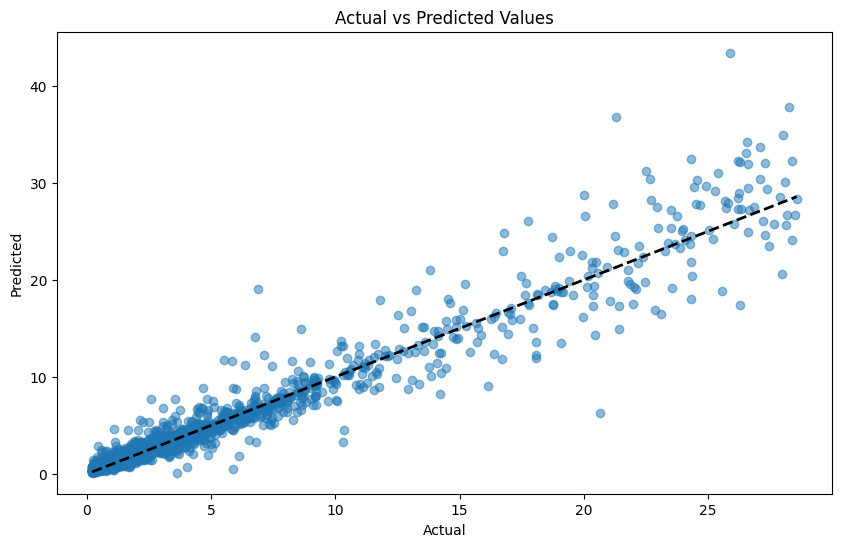

In [73]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()


